# Lab | Unsupervised learning intro (GNOD - part 4)
#### Instructions
It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of songs in the hope that the user will enjoy the new song.. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The activities you did with the Spotify API and the PopVortex web scraping will allow you to create a pipeline such that when the user enters a song, you:

Check whether or not the input song is in the PopVortex Hot 100.
Recommend another Hot 100 song
If it is NOT in the hot 100, then collect the audio features from the Spotify API for the input song.
You want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.
Then you recommend a song from the same cluster number.
Your model will be even more accurate the more songs you use to create your clusters in your model, so you want to have as many songs as possible to create the clustering model. You can find some larger datasets on Kaggle containing more songs with audio features that have already been scraped and saved as a .csv file. You can add these to your own scraped data.

# Clustering

## Import Libraries

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from random import randint
from time import sleep
from itertools import islice
from pandas import json_normalize
import numpy as np

## Load data

In [2]:
top_songs = pd.read_csv('topsongs.csv')
top_songs

,Song,Artist
0,Cruel Summer,Taylor Swift
1,Paint The Town Red,Doja Cat
2,Is It Over Now? (Taylor's Version) [From The V...,Taylor Swift
3,Snooze,SZA
4,Standing Next To You,Jung Kook
...,...,...
195,Those Who Leave Will Not Return,Luminara Stellaris
196,Christmas Canon Rock,Trans-Siberian Orchestra
197,In My Life,The Beatles
198,White Christmas,Bing Crosby


In [3]:
# Rename columns
top_songs = top_songs.rename(columns={'Song': 'song', 'Artist': 'artists'})
top_songs.head()

,song,artists
0,Cruel Summer,Taylor Swift
1,Paint The Town Red,Doja Cat
2,Is It Over Now? (Taylor's Version) [From The V...,Taylor Swift
3,Snooze,SZA
4,Standing Next To You,Jung Kook


## Creating a DataFrame from the Spotify Tracks Dataset

In [4]:
spotify_tracks = pd.read_csv('dataset.csv')
spotify_tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
spotify_tracks.shape

(114000, 21)

## Preparing the DataFrame

In [6]:
# Import Libraries
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

### Reducing columns

In [7]:
spotify_tracks.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

Most of the data we have is not needed for the clustering process, we only keep the audio features.

In [8]:
sp_tracks = spotify_tracks[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']]
sp_tracks.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

### Cleaning

In [9]:
# Check nan values
sp_tracks.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

In [10]:
# Checking types
sp_tracks.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

There is nothing to clean.

### Scaling

In [11]:
scaler = StandardScaler().fit(sp_tracks)
scaler

StandardScaler()

In [12]:
normalized = scaler.transform(sp_tracks)
df_normalized = pd.DataFrame(normalized, columns=sp_tracks.columns)

In [13]:
df_normalized.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.629244,-0.717148,-1.210442,0.300828,-1.326281,0.551848,-0.850202,-0.504109,0.758743,0.929306,-1.141863
1,-0.845908,-1.889980,-1.210442,-1.784744,0.753988,-0.078993,1.831732,-0.504094,-0.591211,-0.798690,-1.489717
2,-0.742186,-1.122669,-1.491343,-0.293288,0.753988,-0.273826,-0.315499,-0.504112,-0.507167,-1.365688,-1.528312
3,-1.733304,-2.312994,-1.491343,-2.039252,0.753988,-0.457309,1.774593,-0.503883,-0.428376,-1.276974,1.987859
4,0.295030,-0.788711,-0.929541,-0.282750,0.753988,-0.303145,0.463399,-0.504112,-0.686285,-1.184403,-0.073348


## Clustering with KMeans

We use a clustering algorithm, like K-Means, to group the songs.

Each step is a part of the process to cluster the songs based on their audio features. The goal is to have songs with similar features in the same cluster, which can then be used to make recommendations. For example, if a user likes a song from cluster 6, other songs from cluster 6 might also be appealing to that user.

In [14]:
# Initializing the classifier
kmeans = cluster.KMeans(n_clusters=10)

In [15]:
# These are the features we want to train on
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Initialize the KMeans model
kmeans = KMeans(n_clusters=10, random_state=42)

# Fit the KMeans model to the selected features
kmeans.fit(df_normalized[features])

/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=42)

In [16]:
# Calculating the clusters
pred = kmeans.predict(df_normalized[features])

In [17]:
# We now have predictions for all our songs
len(pred)

114000

In [18]:
# Separate into 10 clusters
pd.DataFrame(pred)[0].unique()

array([3, 0, 2, 4, 7, 6, 9, 1, 8, 5], dtype=int32)

In [19]:
print(kmeans.cluster_centers_.shape)

(10, 11)


### Evaluation

In [20]:
# Looking at inertia
kmeans.inertia_ 

616086.6070005946

### Choosing k

/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

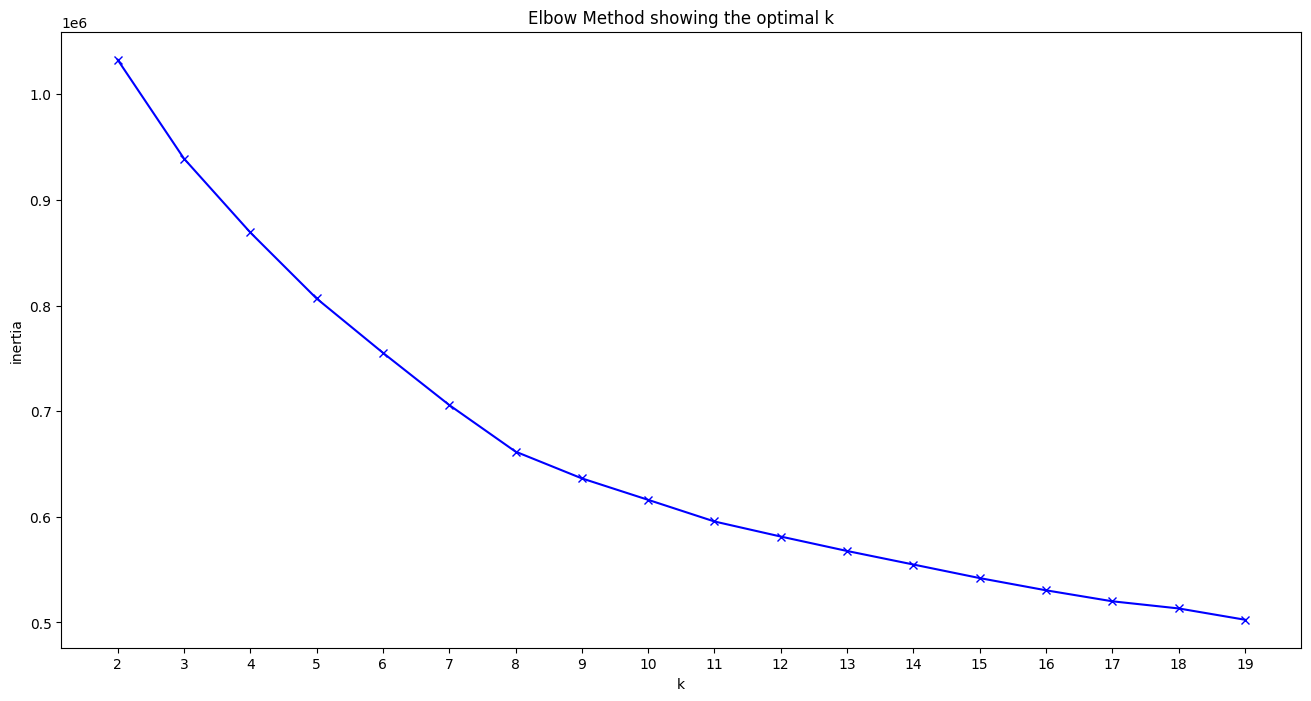

In [21]:
# We try out different values for K
# Since grouping music in just 2 categories is just not useful we start off with 10
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(df_normalized[features])
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.show()

Looking at the plot:

- The x-axis, labeled as 'k', represents the number of clusters.
- The y-axis, labeled as 'Inertia', represents the sum of squared distances of samples to their nearest cluster center.

The plot shows a smooth curve decreasing as the number of clusters k increases, which is expected since increasing the number of clusters will always reduce the distance to the nearest cluster center (until k equals the number of points, at which the inertia is zero).

However, **this plot doesn't show a clear elbow**, which can sometimes happen with complex datasets.  

Since there's no clear elbow, it suggests that there might not be a natural number of clusters that fits the data well, or that the number of clusters that minimizes inertia without overfitting could be subjective.

In such cases, other methods besides the elbow method might be used to help decide on the number of clusters, such as the silhouette score, or domain knowledge about the data might inform the decision. It's also possible that K-Means clustering may not be the best model for this dataset, and exploring different clustering algorithms might yield more definitive clustering. 

### Silhouette score

To help decide on the number of clusters.

In [22]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# We try out different values for K
K = range(2, 20)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(df_normalized[features])
    clusters = kmeans.predict(df_normalized[features])
    silhouette_avg = silhouette_score(df_normalized[features], clusters)
    silhouette_scores.append(silhouette_avg)

/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

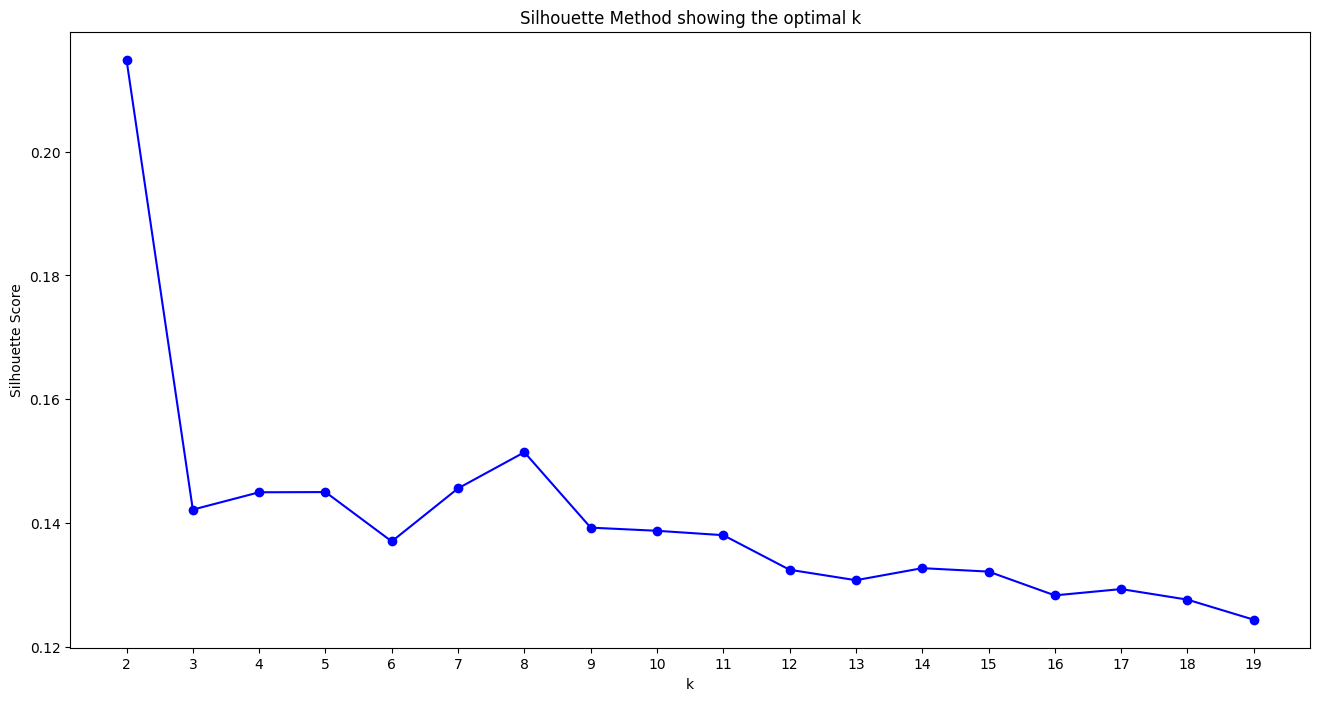

In [24]:
# Plotting the silhouette scores
plt.figure(figsize=(16, 8))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')
plt.show()

### Choosing/Comparing Clusters 15 and 17

In [25]:
# Apply the K-Means algorithm with 15 clusters.
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(df_normalized[features])

# Assign the cluster labels from K-Means to the DataFrame to see which cluster each song belongs to.
df_normalized['cluster'] = kmeans.labels_

# Count how many songs are in each cluster.
cluster_counts = df_normalized['cluster'].value_counts().sort_index()

# Print the counts for each cluster.
print(cluster_counts)

/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0     10115
1      8610
2      6659
3     12851
4      7922
5      7321
6      4449
7       921
8      7021
9      6929
10     8519
11     6148
12     6033
13     9519
14    10983
Name: cluster, dtype: int64


In [26]:
# Apply the K-Means algorithm with 15 clusters.
kmeans = KMeans(n_clusters=17, random_state=42)
kmeans.fit(df_normalized[features])

# Assign the cluster labels from K-Means to the DataFrame to see which cluster each song belongs to.
df_normalized['cluster'] = kmeans.labels_

# Count how many songs are in each cluster.
cluster_counts = df_normalized['cluster'].value_counts().sort_index()

# Print the counts for each cluster.
print(cluster_counts)

/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0     10382
1      8700
2      5977
3      5258
4      6834
5      8299
6      4377
7      6376
8      8324
9      9781
10     5628
11     7742
12     6976
13     7293
14     4662
15      922
16     6469
Name: cluster, dtype: int64


In [27]:
# Cluster sizes for 15 clusters
sizes_15 = np.array([10115, 8610, 6659, 12851, 7922, 7321, 4449, 921, 7021, 6929, 8519, 6148, 6033, 9519, 10983])

# Cluster sizes for 17 clusters
sizes_17 = np.array([6640, 5983, 8610, 7733, 7021, 4434, 6929, 10963, 6148, 8519, 921, 10115, 7321, 4449, 5155, 6186, 6873])

# Calculate the standard deviation for both
std_15 = np.std(sizes_15)
std_17 = np.std(sizes_17)

std_15, std_17

(2730.619709882722, 2242.661493492601)

The standard deviation for the cluster sizes with 15 clusters is approximately 2730, whereas for 17 clusters it's approximately 2242. A lower standard deviation indicates a more evenly distributed set of clusters. Therefore, the distribution of songs across **the clusters is more even with 17 clusters** than with 15 clusters. 

In [28]:
kmeans = KMeans(n_clusters=17, random_state=42)
kmeans.fit(df_normalized[features])

# Assign the cluster labels to a new column in sp_tracks DataFrame
spotify_tracks['cluster'] = kmeans.labels_

# Now sp_tracks will have a new column 'cluster' with the cluster assignments

/Users/mac/anaconda3/envs/nahuelito/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
spotify_tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,5
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,16
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,16
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,16


In [30]:
df_final = spotify_tracks[['artists', 'track_name', 'cluster']].copy()
df_final.head()

,artists,track_name,cluster
0,Gen Hoshino,Comedy,5
1,Ben Woodward,Ghost - Acoustic,16
2,Ingrid Michaelson;ZAYN,To Begin Again,16
3,Kina Grannis,Can't Help Falling In Love,3
4,Chord Overstreet,Hold On,16


In [31]:
df_final.rename(columns={'track_name': 'song'}, inplace=True)
df_final.head(20)

,artists,song,cluster
0,Gen Hoshino,Comedy,5
1,Ben Woodward,Ghost - Acoustic,16
2,Ingrid Michaelson;ZAYN,To Begin Again,16
3,Kina Grannis,Can't Help Falling In Love,3
4,Chord Overstreet,Hold On,16
5,Tyrone Wells,Days I Will Remember,12
6,A Great Big World;Christina Aguilera,Say Something,3
7,Jason Mraz,I'm Yours,12
8,Jason Mraz;Colbie Caillat,Lucky,9
9,Ross Copperman,Hunger,1


# Saving

In [32]:
df_final.head()

,artists,song,cluster
0,Gen Hoshino,Comedy,5
1,Ben Woodward,Ghost - Acoustic,16
2,Ingrid Michaelson;ZAYN,To Begin Again,16
3,Kina Grannis,Can't Help Falling In Love,3
4,Chord Overstreet,Hold On,16


In [33]:
spotify_tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,5
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,16
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,16
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,16


In [34]:
top_songs.head()

,song,artists
0,Cruel Summer,Taylor Swift
1,Paint The Town Red,Doja Cat
2,Is It Over Now? (Taylor's Version) [From The V...,Taylor Swift
3,Snooze,SZA
4,Standing Next To You,Jung Kook


In [35]:
df_final.to_csv('df_final.csv', index=False) 
spotify_tracks.to_csv('spotify_tracks_final.csv', index=False)
top_songs.to_csv('topsongs_final.csv', index=False) 

# Saving KMeans Model and Scaler with Pickle

In [36]:
import pickle

In [37]:
print(kmeans.cluster_centers_.shape)

(17, 11)


In [38]:
# Save the KMeans model
with open('kmeans.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)